In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import random

# from data.data_accessors import tmprss2_to_pandas
import numpy as np
from rdkit import Chem, DataStructs
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score

import pickle

random.seed(1)

os.chdir('/Users/JacobUmans/tmprss2/notebooks')

In [2]:
# collect dataset
assays = pd.read_pickle('../processed_data/combined_dataset.pkl')
assays = assays[assays.activity_target.isin(['Active', 'Inactive'])]  # get rid of any 'Inconclusive'

dcm = pd.read_pickle('../processed_data/DarkChemicalMatter_processed.pkl.gz')

# testing data:
screening_data = pd.read_pickle('../processed_data/screening_data_processed.pkl')

In [3]:
screening_data

,source,name,morgan_fingerprint
0,drugbank,Bivalirudin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,drugbank,Leuprolide,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,drugbank,Goserelin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,drugbank,Gramicidin D,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,drugbank,Desmopressin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
21019,broad,zotepine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
21020,broad,zoxazolamine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21021,broad,zoxazolamine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21022,broad,ZSTK-474,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [4]:
X_assays = np.stack(assays.morgan_fingerprint)
y_assays = np.log10(assays.acvalue_scaled_to_tmprss2.fillna(assays.acvalue_target))

X_test = np.stack(screening_data.morgan_fingerprint)

In [5]:
#split training and testing data for each dataset
train_X, test_X, train_y, test_y = train_test_split(X_assays, y_assays, test_size=0.2)

In [6]:
# Use SKLearn GridSearch CV function to identify optimal C parameter for SVM regression (training set)
Cs = np.logspace(-6, -1, 10)
clf = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(train_X, train_y) 
c_param = clf.best_estimator_.C


In [7]:
c_param

0.1

SVR RMSE:1.3513823503698492
(0.6199093623075893, 2.193561907708448e-20)


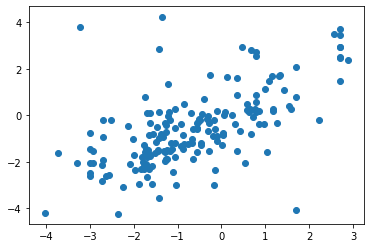

In [8]:
#Run SVM regression using SKLearn on test set. Linear regression for prediction accuracy
svmReg = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param))
svmReg.fit(train_X, train_y)

pred = svmReg.predict(test_X)
MSE = mean_squared_error(test_y, pred)
RMSE = np.sqrt(MSE)
print("SVR RMSE:{}".format(RMSE))

plt.scatter(test_y, pred)
corr = scipy.stats.pearsonr(test_y, pred)
print(corr)

In [9]:
#SKLearn C parameter optimization

Cs = np.logspace(-6, -1, 10)
clf_full = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf_full.fit(X_assays, y_assays) 
c_param_full = clf_full.best_estimator_.C

/Users/JacobUmans/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [10]:
c_param_full

0.0005994842503189409

In [11]:
#Run regressor (trained on full dataset)

svmReg_full = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param_full))
svmReg_full.fit(X_assays, y_assays)
pred_values = svmReg_full.predict(X_test)

In [28]:
argsort = np.argsort(pred_values)
compounds_sorted = screening_data.name[argsort]
pred_values_sorted = pred_values[argsort]


In [26]:
compounds_sorted[1:20]


10806                                           LF-22-0542
14596                                             EVP-6124
17968                                          PF-05212384
8442                                          Talsaclidine
17981                                            PF-477736
17979                                            PF-477736
17978                                           PF-4708671
17980                                            PF-477736
6616     2-Methyl-2-propanyl [(1S)-2-methyl-1-(1,3,4-ox...
8432                                           Seviteronel
13750                                           decitabine
13749                                         decernotinib
1136                                           Varenicline
7765                                          Medetomidine
15121                                            glycitein
18643                                             rac-BHFF
4743                                               SNS-0

In [29]:
pred_values_sorted[1:20]

array([-1.90949604, -1.82469398, -1.78119203, -1.75815426, -1.73721716,
       -1.73721716, -1.73721716, -1.73721716, -1.66673779, -1.66153273,
       -1.66153273, -1.66153273, -1.61879022, -1.61827738, -1.60529267,
       -1.5859216 , -1.5859216 , -1.54725261, -1.54709986])

Text(0.5, 1.0, 'SVM Validation Data')

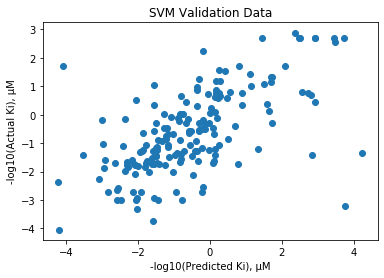

In [15]:
plt.scatter(pred, test_y)
plt.xlabel('log10(Predicted Ki), μM')
plt.ylabel('log10(Actual Ki), μM')
plt.title('SVM Validation Data')

(array([2.000e+00, 1.400e+01, 2.800e+01, 7.400e+01, 2.290e+02, 5.880e+02,
        1.367e+03, 2.529e+03, 3.939e+03, 4.449e+03, 3.230e+03, 2.239e+03,
        1.221e+03, 5.640e+02, 2.790e+02, 1.750e+02, 5.100e+01, 2.400e+01,
        6.000e+00, 3.000e+00]),
 array([-2.12098537, -1.85819953, -1.59541369, -1.33262785, -1.06984201,
        -0.80705617, -0.54427033, -0.28148449, -0.01869865,  0.2440872 ,
         0.50687304,  0.76965888,  1.03244472,  1.29523056,  1.5580164 ,
         1.82080224,  2.08358808,  2.34637392,  2.60915976,  2.8719456 ,
         3.13473144]),
 <a list of 20 Patch objects>)

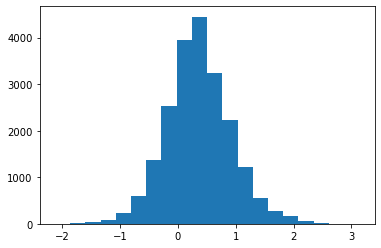

In [16]:
plt.hist(pred_values_sorted, bins = 20)